# Rational Quadratic Spline

In [1]:
# @title Install Packages
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here", "setup.py"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [38]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
import chex

config.update("jax_enable_x64", False)

import numpy as np
from functools import partial
from sklearn.preprocessing import StandardScaler

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
import corner

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# get data
n_samples = 1_500
n_features = 1
data = get_classic(n_samples)[:, 1].reshape(-1, 1)


# Normalize Data
data = StandardScaler().fit_transform(data)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

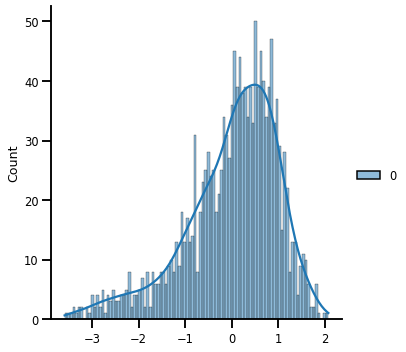

In [4]:
data = jnp.array(data, dtype=jnp.float32)

sns.displot(data, bins=100, kde=True)

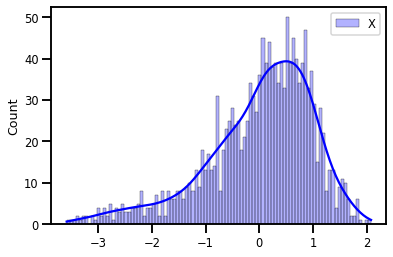

In [5]:
fig, ax = plt.subplots()

sns.histplot(
    data.squeeze(),
    bins=100,
    label="X",
    fill=True,
    kde=True,
    ax=ax,
    color="blue",
    alpha=0.3,
)
# plt.savefig("./rsq_uni.png")
ax.legend()
plt.show()

## Spline Transformation

In [6]:
from rbig_jax.transforms.parametric.splines import InitPiecewiseRationalQuadraticCDF

#### Initialization

In [7]:
range_min = -5.0
range_max = 5.0
boundary_slopes = "unconstrained"
n_bins = 10
n_features = 1
identity_init = True
min_knot_slope = 1e-4
min_bin_size = 1e-4
shape = (1,)
key = jax.random.PRNGKey(123)

In [8]:
init_rsq_f = InitPiecewiseRationalQuadraticCDF(
    n_bins=n_bins,
    range_min=range_min,
    range_max=range_max,
    boundary_slopes=boundary_slopes,
    identity_init=identity_init,
    min_bin_size=min_bin_size,
    min_knot_slope=min_knot_slope,
)

rqs_bijector = init_rsq_f(key, shape)

#### Forward Function

In [9]:
outputs = rqs_bijector.forward(data)

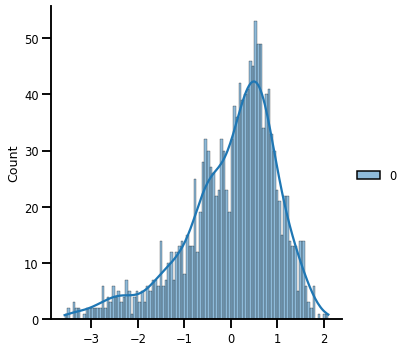

In [10]:
sns.displot(outputs, bins=100, kde=True)

In [11]:
X_approx = rqs_bijector.inverse(outputs)

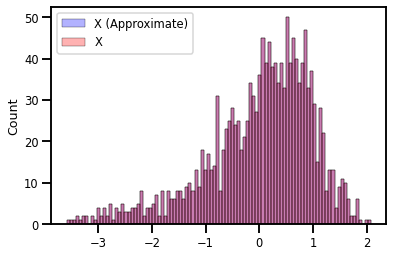

In [12]:
fig, ax = plt.subplots()
sns.histplot(
    X_approx.squeeze(),
    bins=100,
    label="X (Approximate)",
    fill=True,
    ax=ax,
    color="blue",
    alpha=0.3,
)
sns.histplot(
    data.squeeze(), bins=100, label="X", fill=True, ax=ax, color="Red", alpha=0.3
)
ax.legend()
plt.show()

## Data

In [13]:
from rbig_jax.data import DensityDataset, collate_fn
import torch.multiprocessing as multiprocessing
from torch.utils.data import DataLoader

# multiprocessing.set_start_method("spawn")

# initialize dataset
ds = DensityDataset(np.array(data))

# initialize dataloader
batch_size = 128
shuffle = True

dl = DataLoader(
    ds, batch_size=batch_size, shuffle=shuffle, collate_fn=None, num_workers=0
)

### Training

In [14]:
import jax.numpy as jnp
from rbig_jax.training import init_log_prob
from rbig_jax.loss import init_nll_loss
from distrax._src.distributions.normal import Normal

In [15]:
# init base distribtion (Gaussian)
base_dist = Normal(0.0, 1.0)

# create log probability
log_prob = init_log_prob(base_dist)

# create loss function
nll_loss = init_nll_loss(log_prob)

In [16]:
from jax.experimental import optimizers
from rbig_jax.training import init_train_op, train_model


lr = 0.01
optimizer = optimizers.adam
jitted = True
epochs = 100

# initialize training procedure
train_op, opt_params = init_train_op(
    rqs_bijector, nll_loss, optimizer, lr=lr, jitted=jitted
)

# train model
final_bijector, losses = train_model(train_op, opt_params, dl, epochs=epochs,)

100%|██████████| 100/100 [00:03<00:00, 26.32it/s, loss=1.3207]


### Results

In [17]:
final_bijector.x_pos.shape

(1, 11)

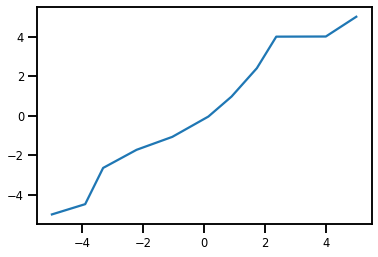

In [18]:
plt.plot(final_bijector.x_pos.squeeze(), final_bijector.y_pos.squeeze())

#### CDF

In [19]:
X_trans = final_bijector.forward(data)

<Figure size 432x288 with 0 Axes>

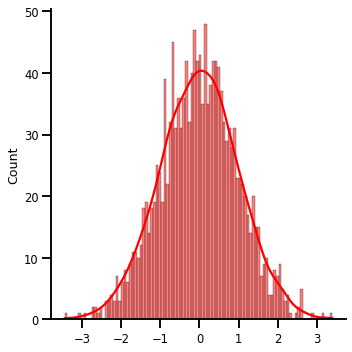

In [20]:
fig = plt.figure()
sns.displot(X_trans.squeeze(), bins=100, label="CDF", kde=True, fill=True, color="red")
# plt.savefig("./rsq_mg_uni.png")
plt.show()

#### Log PDF

In [21]:
X_ldj = final_bijector.forward_log_det_jacobian(data)

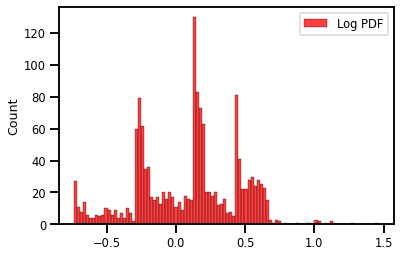

In [22]:
fig, ax = plt.subplots()
sns.histplot(X_ldj.squeeze(), bins=100, label="Log PDF", fill=True, ax=ax, color="red")
ax.legend()
plt.show()

In [23]:
X_approx = final_bijector.inverse(X_trans)

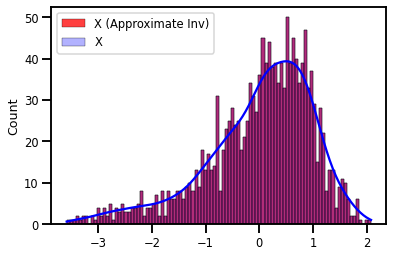

In [24]:
fig, ax = plt.subplots()
sns.histplot(
    X_approx.squeeze(),
    bins=100,
    label="X (Approximate Inv)",
    fill=True,
    ax=ax,
    color="red",
)
sns.histplot(
    data.squeeze(),
    bins=100,
    label="X",
    fill=True,
    kde=True,
    ax=ax,
    color="blue",
    alpha=0.3,
)
# plt.savefig("./rsq_mg_uni_inv.png")
ax.legend()
plt.show()

## 2D Example

In [25]:
# get data
n_samples = 5_000
n_features = 2
data = get_classic(n_samples)

from sklearn.preprocessing import StandardScaler

data = StandardScaler().fit_transform(data)

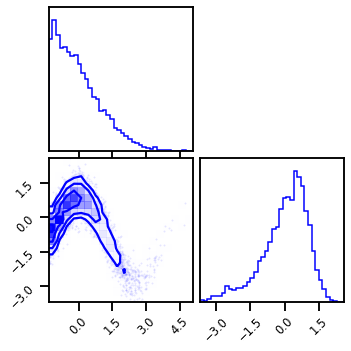

In [26]:
fig = corner.corner(data, color="blue", hist_bin_factor=2)
# fig.savefig("demo_1d")

In [27]:
from rbig_jax.data import DensityDataset, collate_fn
import torch.multiprocessing as multiprocessing
from torch.utils.data import DataLoader

# multiprocessing.set_start_method("spawn")

# initialize dataset
ds = DensityDataset(np.array(data))

# initialize dataloader
batch_size = 128
shuffle = True

dl = DataLoader(
    ds, batch_size=batch_size, shuffle=shuffle, collate_fn=None, num_workers=0
)

### Model

In [28]:
range_min = -10.0
range_max = 10.0
boundary_slopes = "identity"
n_bins = 20
n_features = 2
identity_init = False
min_knot_slope = 1e-4
min_bin_size = 1e-4
shape = (2,)
key = jax.random.PRNGKey(123)

In [29]:
init_rsq_f = InitPiecewiseRationalQuadraticCDF(
    n_bins=n_bins,
    range_min=range_min,
    range_max=range_max,
    boundary_slopes=boundary_slopes,
    identity_init=identity_init,
    min_bin_size=min_bin_size,
    min_knot_slope=min_knot_slope,
)

rqs_bijector = init_rsq_f(key, shape)

In [30]:
# init base distribtion (Gaussian)
base_dist = Normal(0.0, 1.0)

# create log probability
log_prob = init_log_prob(base_dist)

# create loss function
nll_loss = init_nll_loss(log_prob)

In [31]:
from jax.experimental import optimizers
from rbig_jax.training import init_train_op, train_model


lr = 0.01
optimizer = optimizers.adam
jitted = True
epochs = 50

# initialize training procedure
train_op, opt_params = init_train_op(
    rqs_bijector, nll_loss, optimizer, lr=lr, jitted=jitted
)

# train model
rqs_bijector_trained, losses = train_model(train_op, opt_params, dl, epochs=epochs,)

100%|██████████| 50/50 [00:05<00:00,  8.74it/s, loss=2.5834]


#### CDF

In [32]:
X_trans = rqs_bijector_trained.forward(data)

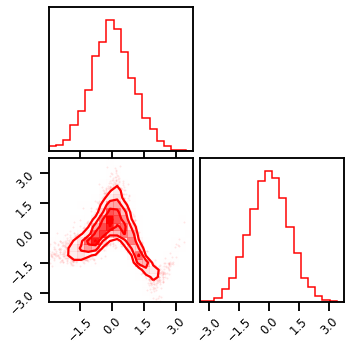

In [33]:
fig = corner.corner(X_trans, color="Red")
# fig.savefig("rsq_mg")

### Inverse Transform

In [34]:
X_approx = rqs_bijector_trained.inverse(X_trans)

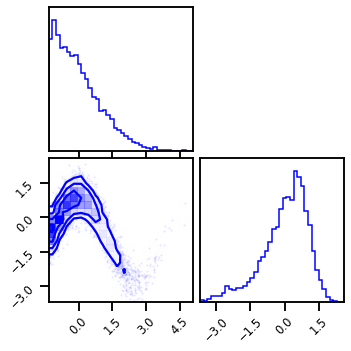

In [35]:
fig = corner.corner(X_approx, color="blue", hist_bin_factor=2)
# fig.savefig("rsq_mg_2d_inv")